This notebook follows the case study example from https://github.com/cybera/case-study-example/blob/main/EDA_ookla_dataset.ipynb

Yukon boundaries data acquired from https://mapservices.gov.yk.ca/GeoYukon/
 - Electoral districts

In [ ]:
# To do: 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
# Install and import modules

!pip install geopandas rtree pysal --quiet
import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
from shapely.geometry import Polygon
import os
import pysal # PySAL: python Spatial Analysis Library
import mapclassify as mc
import matplotlib.pyplot as plt
import pickle
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')
print(os.getcwd())

province = 'Yukon'
province_short = 'YK'
years = ['2019', '2020', '2021']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

/content/drive/MyDrive/shared/ssc22-case-comp/dataset


In [3]:
# Define w_avg()

def w_avg(df, name_col, val_cols, w_col='tests'):
    """ Computes weighted averages of specified columns"""
    '''
    df: target data frame.
    name_col: String. The grouping column.
    val_cols: list of strings. Names of the columns to average over.
    w_col: String. Name of the column that is used for weighting the averages.
    '''
    
    names = df[name_col].unique()
    col_list = [name_col, val_cols[0], val_cols[1], val_cols[2], w_col]
    result_df = pd.DataFrame(columns = col_list)    
    for name in names:
        # extract a group
        temp_table = df[df[name_col]==name] 
        # compute the weightes averages
        temp_d_avg = np.average(temp_table[val_cols[0]], weights=temp_table[w_col])
        temp_u_avg = np.average(temp_table[val_cols[1]], weights=temp_table[w_col])
        temp_l_avg = np.average(temp_table[val_cols[2]], weights=temp_table[w_col])
        temp_w = np.sum(temp_table[w_col])
        # add the averages to the result dataframe
        result_df = result_df.append(dict(zip(col_list, [name, temp_d_avg, temp_u_avg, temp_l_avg, temp_w])), ignore_index=True)
    return result_df

# # test run 
# test_df = data_in_ab_counties.head(10000)
# w_avg(test_df, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')


Index(['ELECT_NUM', 'ELECT_NAME', 'FR_ELECNAM', 'geometry'], dtype='object')
['Vuntut Gwitchin' 'Kluane' 'Klondike' 'Mayo-Tatchun' 'Pelly-Nisutlin'
 'Watson Lake' 'Lake Laberge' 'Riverdale North' 'Riverdale South'
 'Porter Creek Centre' 'Porter Creek South' 'Porter Creek North'
 'Whitehorse Centre' 'Mountainview' 'Whitehorse West' 'Copperbelt North'
 'Copperbelt South' 'Takhini-Kopper King' 'Mount Lorne-Southern Lakes']
Index(['ELECT_NUM', 'ELECT_NAME', 'FR_ELECNAM', 'geometry'], dtype='object')


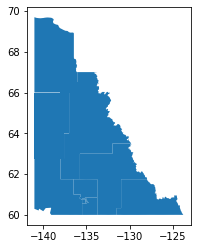

In [40]:
## Load the municipal boundaries data
file_path = './' + province +  '/municipal_boundaries/Electoral districts/'

counties = gpd.read_file(file_path).to_crs(4326)

# check the column names to match the names of the municipality columns
print(counties.columns)
# print(counties.head(5))
# print(counties['ELECT_NAME'].unique())


# check the boundaries
counties.plot()
print(counties.columns)

In [49]:
# rename the name column to 'GEONAME'
counties.rename(columns={'ELECT_NAME':'GEONAME'}, inplace=True) 
counties['GEONAME'].unique()

array(['Vuntut Gwitchin', 'Kluane', 'Klondike', 'Mayo-Tatchun',
       'Pelly-Nisutlin', 'Watson Lake', 'Lake Laberge', 'Riverdale North',
       'Riverdale South', 'Porter Creek Centre', 'Porter Creek South',
       'Porter Creek North', 'Whitehorse Centre', 'Mountainview',
       'Whitehorse West', 'Copperbelt North', 'Copperbelt South',
       'Takhini-Kopper King', 'Mount Lorne-Southern Lakes'], dtype=object)

In [45]:
##### Data prep stage ####

i_yq_data = {} # placeholder for the geoDataFrames

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        
        yq = str(year) + '-' + str(quarter)
        print('processing {yq}'.format(yq=yq))
        
        i_file_path = './' + province + '/by_year_quarter/' + province + '-' + yq + '.shp'
        i_data = gpd.read_file(i_file_path)
        i_ab_data = i_data.to_crs(4326) # to match the crs types

        i_joint_data = gpd.sjoin(i_ab_data, counties, how='inner', predicate='intersects') # comp. bottleneck
        
        # Convert kbps --> Mbps for easier reading
        i_joint_data['avg_d_mbps'] = i_joint_data['avg_d_kbps']/1000
        i_joint_data['avg_u_mbps'] = i_joint_data['avg_u_kbps']/1000

        i_w_data = w_avg(i_joint_data, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')

        i_county_data = counties[['GEONAME', 'geometry']].merge(i_w_data, on='GEONAME').to_crs(3401)
        
        labels1 = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]
        i_county_data['group1'] = pd.cut(i_county_data['avg_d_mbps'], (0, 25, 50, 100, 150, 200), right=False, labels = labels1)
        
        labels2 = ["<50 Mbps", ">=50 Mbps"]
        i_county_data['group2'] = pd.cut(i_county_data['avg_d_mbps'], (0, 50, 200), right=False, labels = labels2)

        i_yq_data[yq] = i_county_data
    

processing 2019-Q1
processing 2019-Q2
processing 2019-Q3
processing 2019-Q4
processing 2020-Q1
processing 2020-Q2
processing 2020-Q3
processing 2020-Q4
processing 2021-Q1
processing 2021-Q2
processing 2021-Q3
processing 2021-Q4


In [52]:
print(i_yq_data['2021-Q4'])

                       GEONAME  \
0                       Kluane   
1                     Klondike   
2                 Mayo-Tatchun   
3               Pelly-Nisutlin   
4                  Watson Lake   
5                 Lake Laberge   
6              Riverdale North   
7              Riverdale South   
8          Porter Creek Centre   
9           Porter Creek South   
10          Porter Creek North   
11           Whitehorse Centre   
12                Mountainview   
13             Whitehorse West   
14            Copperbelt North   
15            Copperbelt South   
16         Takhini-Kopper King   
17  Mount Lorne-Southern Lakes   

                                             geometry  avg_d_mbps  avg_u_mbps  \
0   POLYGON ((-1104357.965 6906887.038, -1104729.7...    9.172778    0.741889   
1   POLYGON ((-919570.194 7529546.016, -933327.855...   87.489990   11.926979   
2   POLYGON ((-734840.010 7124482.802, -735035.631...   14.726833   19.992700   
3   POLYGON ((-913432.512 676

In [50]:
out_path = './' + province + '/' + province_short + '_yq_data_by_electoral_districts.p'
with open(out_path, 'wb') as f:
    pickle.dump(i_yq_data, f)
print('{out_path} save complete'.format(out_path = out_path))

./Yukon/YK_yq_data_by_electoral_districts.p save complete


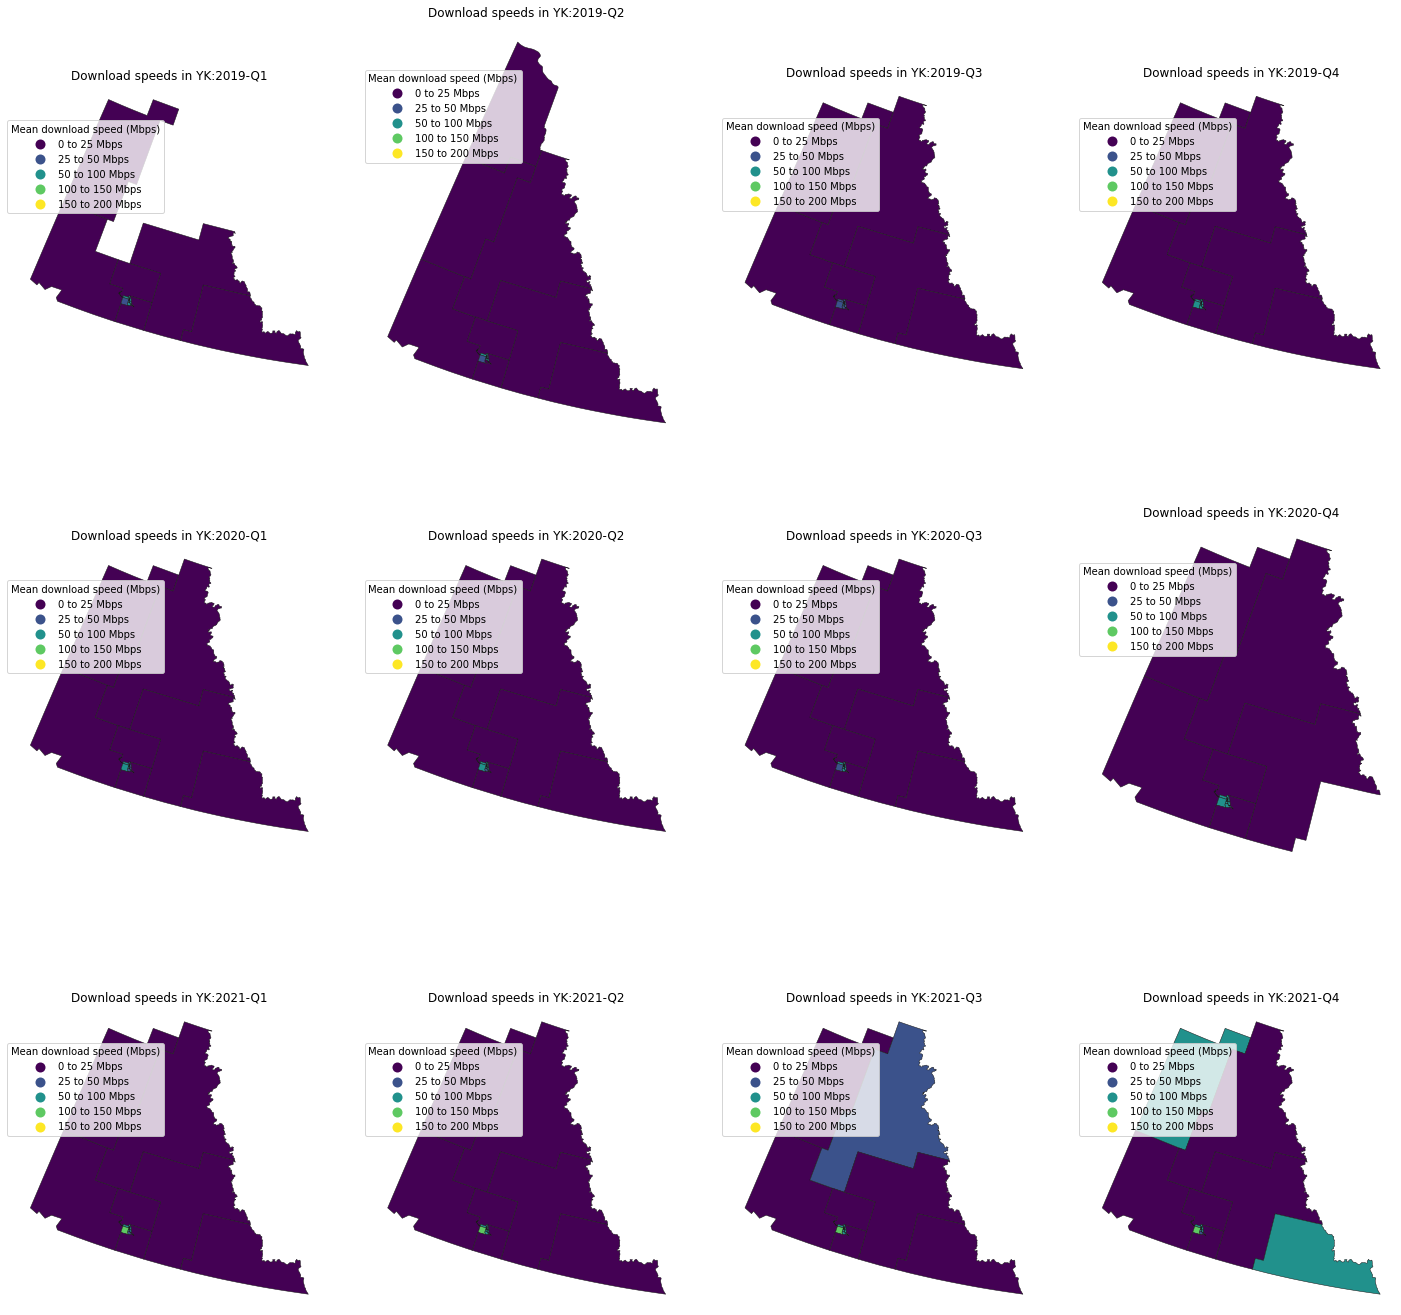

In [47]:
#### Plotting stage: detailed map

fig, axs = plt.subplots(len(years),len(quarters), figsize = (20, 20))

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        df_name = str(year) + '-' + str(quarter)
        i_county_data = i_yq_data[df_name]
        i_ax = axs[i, j]
        i_county_data.plot(column='group1', cmap='viridis', linewidth=0.5, ax=i_ax, edgecolor='0.1', legend=True)
        i_ax.axis('off')
        fig_title = 'Download speeds in ' + province_short + ':' + df_name
        i_ax.set_title(fig_title)
        leg = i_ax.get_legend()
        leg.set_bbox_to_anchor((0.5, 0.9))
        leg.set_title('Mean download speed (Mbps)')
fig.tight_layout()
plt.show()


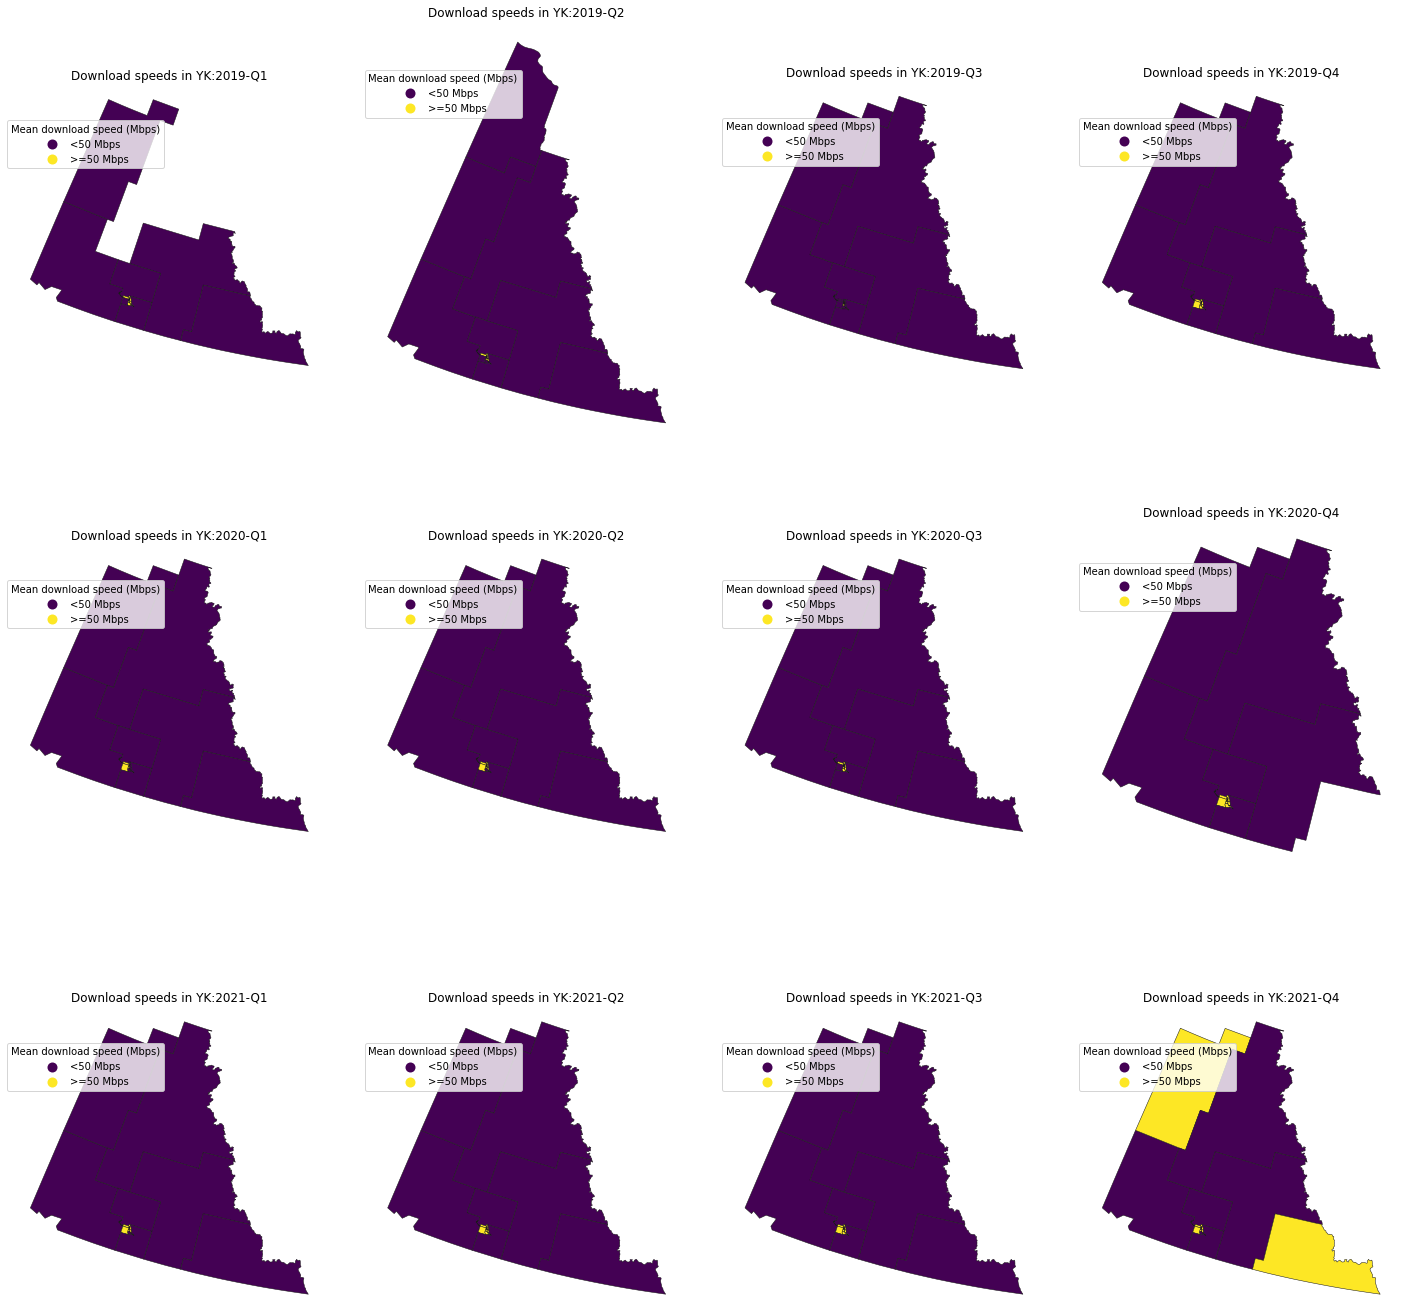

In [51]:
#### Plotting stage: binary map

fig, axs = plt.subplots(len(years),len(quarters), figsize = (20, 20))

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        df_name = str(year) + '-' + str(quarter)
        i_county_data = i_yq_data[df_name]
        i_ax = axs[i, j]
        i_county_data.plot(column='group2', cmap='viridis', linewidth=0.5, ax=i_ax, edgecolor='0.1', legend=True)
        i_ax.axis('off')
        fig_title = 'Download speeds in ' + province_short + ':' + df_name
        i_ax.set_title(fig_title)
        leg = i_ax.get_legend()
        leg.set_bbox_to_anchor((0.5, 0.9))
        leg.set_title('Mean download speed (Mbps)')
fig.tight_layout()
plt.show()
